# Dynamic Network

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

df_dynamic_subset = pd.read_csv(r'granger_data.csv')

# Initialize a dictionary to store networks for each time point
networks = {}

# Get unique time points in sorted order
time_points = sorted(df_dynamic_subset['YearMonth'].unique())


# Loop through each time point and build a network
for time_point in time_points:
    # Subset data for the current time point
    df_time = df_dynamic_subset[df_dynamic_subset['YearMonth'] == time_point]
    
    # Pivot to wide format (rows: participants, columns: questions)
    df_wide = df_time.pivot(index='Participant_Number', columns='Question', values='Score')
    
    # Compute correlation matrix
    corr_matrix = df_wide.corr()
    
    # Create a network using NetworkX (add edges for significant correlations)
    G = nx.Graph()
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.4:  # Correlation threshold
                G.add_edge(corr_matrix.columns[i], corr_matrix.columns[j], weight=corr_matrix.iloc[i, j])
    
    # Store the network for the current time point
    networks[time_point] = G


# Granger Causality

## Means

c:\Users\MadiL\Thesis CodeBase\thesisenv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\MadiL\Thesis CodeBase\thesisenv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


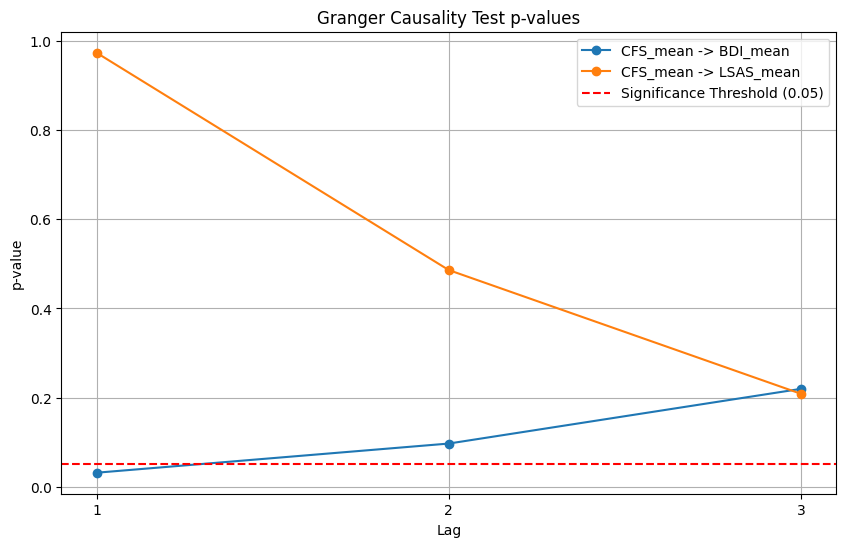

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

# Step 1: Clean the data to ensure no formatting issues
df_dynamic_subset['Question'] = df_dynamic_subset['Question'].str.strip()

# Step 2: Aggregate duplicate entries by taking the mean score for each combination
df_aggregated = df_dynamic_subset.groupby(['YearMonth', 'Participant_Number', 'Question']).mean().reset_index()

# Step 3: Pivot the dataset to wide format
df_pivot = df_aggregated.pivot_table(index='YearMonth', columns='Question', values='Score', aggfunc='mean').sort_index()

# Step 4: Select columns related to CFS, BDI, and LSAS
cfs_columns = [col for col in df_pivot.columns if 'CFS' in col]
bdi_columns = [col for col in df_pivot.columns if 'BDI' in col]
lsas_columns = [col for col in df_pivot.columns if 'LSAS' in col]

# Step 5: Compute the mean score across items for each group at each time point
df_mean_scores = pd.DataFrame({
    'CFS_mean': df_pivot[cfs_columns].mean(axis=1),
    'BDI_mean': df_pivot[bdi_columns].mean(axis=1),
    'LSAS_mean': df_pivot[lsas_columns].mean(axis=1)
}).dropna()  # Drop rows with NaN values

# Step 6: Run Granger causality tests
# Test if CFS_mean Granger-causes BDI_mean
granger_result_bdi = grangercausalitytests(df_mean_scores[['CFS_mean', 'BDI_mean']], maxlag=3, verbose=False)

# Test if CFS_mean Granger-causes LSAS_mean
granger_result_lsas = grangercausalitytests(df_mean_scores[['CFS_mean', 'LSAS_mean']], maxlag=3, verbose=False)

# Step 7: Extract p-values for Granger causality tests
p_values_bdi = [granger_result_bdi[lag][0]['ssr_ftest'][1] for lag in granger_result_bdi]
p_values_lsas = [granger_result_lsas[lag][0]['ssr_ftest'][1] for lag in granger_result_lsas]

# Step 8: Visualize p-values over different lags
lags = range(1, 4)
plt.figure(figsize=(10, 6))
plt.plot(lags, p_values_bdi, marker='o', label='CFS_mean -> BDI_mean')
plt.plot(lags, p_values_lsas, marker='o', label='CFS_mean -> LSAS_mean')
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (0.05)')
plt.xticks(lags)
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.title('Granger Causality Test p-values')
plt.legend()
plt.grid(True)
plt.show()


### Mean Granger Causality Interpretation
The Granger causality test results show whether past values of one time series (in this case, the mean CFS scores) can predict future values of another time series (BDI or LSAS scores). 

Lags:
A lag of 1 means we are testing whether CFS scores from one time point earlier can predict BDI or LSAS scores at the current time point.

A lag of 2 tests whether CFS scores from two time points earlier can predict current BDI or LSAS scores, and so on.

Significance:
A p-value below 0.05 at a given lag suggests significant Granger causality, meaning the past values of CFS significantly predict current values of BDI or LSAS at that lag. In our analysis, CFS scores significantly Granger-cause BDI scores at lags 1 and 2, but not LSAS scores, indicating a potential causative relationship where changes in cognitive flexibility precede changes in depressive symptoms.

c:\Users\MadiL\Thesis CodeBase\thesisenv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\MadiL\Thesis CodeBase\thesisenv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\MadiL\Thesis CodeBase\thesisenv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\MadiL\Thesis CodeBase\thesisenv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\MadiL\Thesis CodeBase\thesisenv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\MadiL\Thesis CodeBase\thesisenv\Lib\site-packa

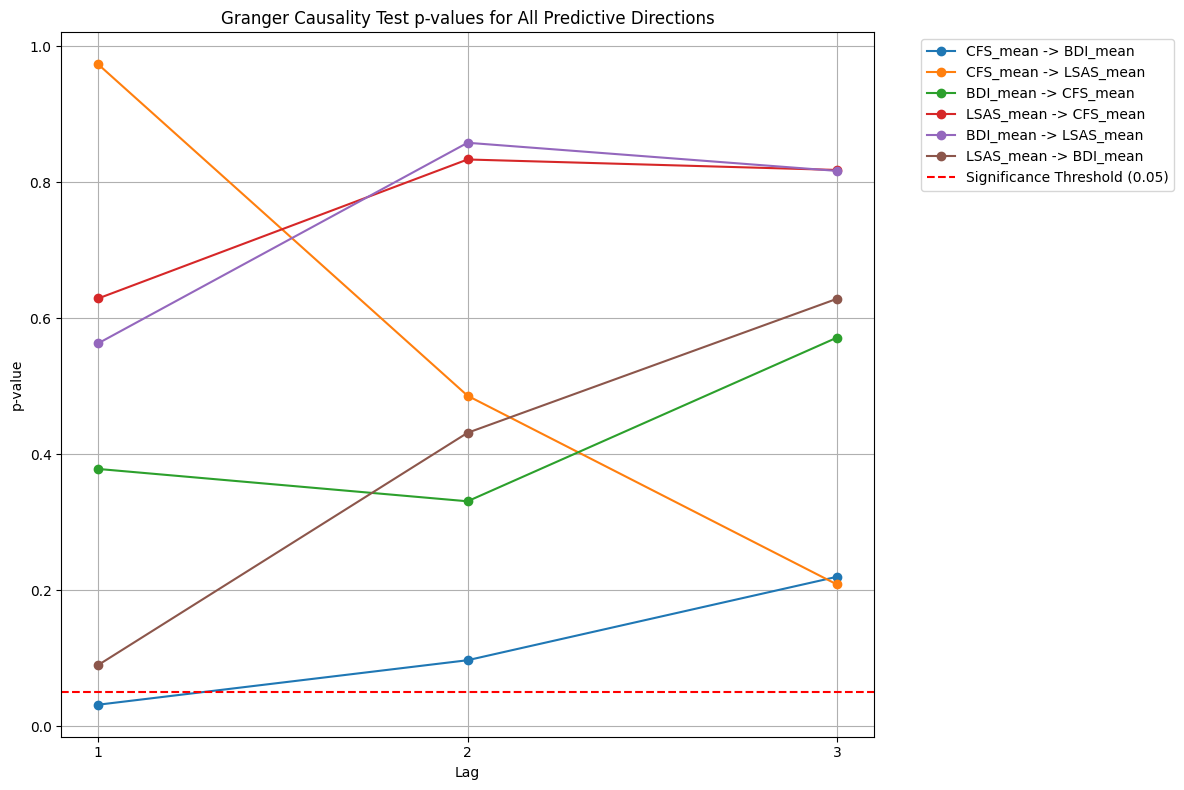

In [4]:


# Compute the mean score across items for each group at each time point
df_mean_scores = pd.DataFrame({
    'CFS_mean': df_pivot[cfs_columns].mean(axis=1),
    'BDI_mean': df_pivot[bdi_columns].mean(axis=1),
    'LSAS_mean': df_pivot[lsas_columns].mean(axis=1)
}).dropna()  # Drop rows with NaN values

# Run Granger causality tests for all predictive directions
granger_tests = {
    'CFS_mean -> BDI_mean': ['CFS_mean', 'BDI_mean'],
    'CFS_mean -> LSAS_mean': ['CFS_mean', 'LSAS_mean'],
    'BDI_mean -> CFS_mean': ['BDI_mean', 'CFS_mean'],
    'LSAS_mean -> CFS_mean': ['LSAS_mean', 'CFS_mean'],
    'BDI_mean -> LSAS_mean': ['BDI_mean', 'LSAS_mean'],
    'LSAS_mean -> BDI_mean': ['LSAS_mean', 'BDI_mean']
}

# Store p-values
p_values = {}

for label, variables in granger_tests.items():
    result = grangercausalitytests(df_mean_scores[variables], maxlag=3, verbose=False)
    p_values[label] = [result[lag][0]['ssr_ftest'][1] for lag in result]

# Visualize p-values over different lags
lags = range(1, 4)
plt.figure(figsize=(12, 8))

for label, values in p_values.items():
    plt.plot(lags, values, marker='o', label=label)

plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (0.05)')
plt.xticks(lags)
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.title('Granger Causality Test p-values for All Predictive Directions')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


## Per-Question

c:\Users\MadiL\Thesis CodeBase\thesisenv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\MadiL\Thesis CodeBase\thesisenv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\MadiL\Thesis CodeBase\thesisenv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\MadiL\Thesis CodeBase\thesisenv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\MadiL\Thesis CodeBase\thesisenv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\MadiL\Thesis CodeBase\thesisenv\Lib\site-packa

     Cause   Effect  Lag 1 p-value  Lag 2 p-value  Lag 3 p-value
465   CFS7  LSAS_18       0.000140       0.006797       0.030797
479   CFS7   LSAS_9       0.000287       0.001964       0.002173
160   CFS6     BDI1       0.000442       0.009896       0.013577
72   CFS12    BDI20       0.000460       0.005945       0.103051
461   CFS7  LSAS_14       0.001468       0.025323       0.094581
..     ...      ...            ...            ...            ...
484   CFS8  LSAS_13       0.943296       0.034313       0.102547
745  BDI18  LSAS_10       0.951824       0.032014       0.035966
926   BDI6  LSAS_22       0.980124       0.968964       0.043029
625  BDI13  LSAS_10       0.989866       0.002094       0.008068
73   CFS12     BDI3       0.999781       0.049657       0.197635

[211 rows x 5 columns]


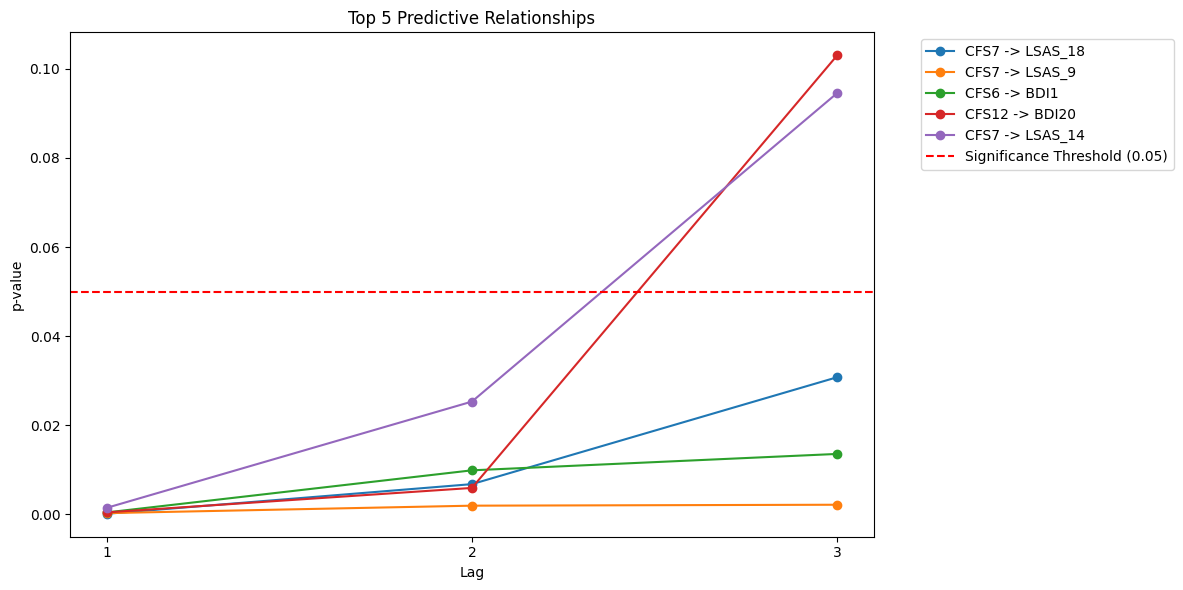

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests


# Run Granger causality tests at the item level
results = []

# Loop through all item pairs between CFS and BDI
for cfs_item in cfs_columns:
    for bdi_item in bdi_columns:
        try:
            test_result = grangercausalitytests(df_pivot[[cfs_item, bdi_item]].dropna(), maxlag=3, verbose=False)
            p_values = [test_result[lag][0]['ssr_ftest'][1] for lag in test_result]
            results.append({'Cause': cfs_item, 'Effect': bdi_item, 'Lag 1 p-value': p_values[0], 'Lag 2 p-value': p_values[1], 'Lag 3 p-value': p_values[2]})
        except Exception as e:
            print(f"Error processing {cfs_item} -> {bdi_item}: {e}")

# Loop through all item pairs between CFS and LSAS
for cfs_item in cfs_columns:
    for lsas_item in lsas_columns:
        try:
            test_result = grangercausalitytests(df_pivot[[cfs_item, lsas_item]].dropna(), maxlag=3, verbose=False)
            p_values = [test_result[lag][0]['ssr_ftest'][1] for lag in test_result]
            results.append({'Cause': cfs_item, 'Effect': lsas_item, 'Lag 1 p-value': p_values[0], 'Lag 2 p-value': p_values[1], 'Lag 3 p-value': p_values[2]})
        except Exception as e:
            print(f"Error processing {cfs_item} -> {lsas_item}: {e}")

# Loop through all item pairs between BDI and LSAS
for bdi_item in bdi_columns:
    for lsas_item in lsas_columns:
        try:
            test_result = grangercausalitytests(df_pivot[[bdi_item, lsas_item]].dropna(), maxlag=3, verbose=False)
            p_values = [test_result[lag][0]['ssr_ftest'][1] for lag in test_result]
            results.append({'Cause': bdi_item, 'Effect': lsas_item, 'Lag 1 p-value': p_values[0], 'Lag 2 p-value': p_values[1], 'Lag 3 p-value': p_values[2]})
        except Exception as e:
            print(f"Error processing {bdi_item} -> {lsas_item}: {e}")

# Make a comprehensive table with p-values at all lags
df_results = pd.DataFrame(results)

# Filter for significant relationships (any lag p-value < 0.05)
df_significant = df_results[(df_results['Lag 1 p-value'] < 0.05) | 
                            (df_results['Lag 2 p-value'] < 0.05) | 
                            (df_results['Lag 3 p-value'] < 0.05)]

# Sort by Lag 1 p-value for significance
df_significant = df_significant.sort_values(by=['Lag 1 p-value'])

# Display the comprehensive table
print(df_significant[['Cause', 'Effect', 'Lag 1 p-value', 'Lag 2 p-value', 'Lag 3 p-value']])

# Visualization 1: Line plot for top 5 strongest relationships
top_5 = df_significant.nsmallest(5, 'Lag 1 p-value')

plt.figure(figsize=(12, 6))
for _, row in top_5.iterrows():
    plt.plot([1, 2, 3], [row['Lag 1 p-value'], row['Lag 2 p-value'], row['Lag 3 p-value']], marker='o', label=f"{row['Cause']} -> {row['Effect']}")

plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (0.05)')
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.title('Top 5 Predictive Relationships')
plt.xticks([1, 2, 3])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
